In [1]:
import json
from pprint import pprint
import csv
import re
import gzip
import numpy as np
import matplotlib.pyplot as plt

# Kidney analysis

In [2]:
#this cell opens the metadata file and create list with: files = [case_id,file_id,file_name]
with open('../kidney clinical data/metadata.cart.2018-11-01.json') as data_file:    
    data = json.load(data_file)

#initialize the array to hold the information
files = []
    
for n in range(len(data)):
    #remove the TARGET project files since clinical data doesn't match
    if not bool('TARGET' in data[n]['associated_entities'][0]['entity_submitter_id']):
        files.append([data[n]['associated_entities'][0]['case_id'],data[n]['file_id'],data[n]['file_name']])
    
pprint(files[0:3])

[['88c91a7b-5c41-4361-85d0-da759ab94204',
  'adadde58-de3b-4cf7-908b-5057831e400e',
  'c08817f0-fc05-44ea-8a92-8b7538ac49d8.FPKM.txt.gz'],
 ['74749fe8-f5d0-4d0d-8c7a-e56eba6503b3',
  'aa7770a2-6fbb-4693-8378-3b5de332deca',
  '3704029d-0bb1-40b5-b666-610174d521c2.FPKM.txt.gz'],
 ['88e7ce26-5b3f-4e4e-89b7-f706063fc467',
  '0e345952-6f09-4e61-b9a9-e8f809bf21e0',
  '6073b31e-7ce7-423e-a9b2-a85e3e9bc62e.FPKM.txt.gz']]


In [3]:
clinical_data = []

with open('../kidney clinical data/clinical.tsv') as tsvin:
    tsvin = csv.reader(tsvin, delimiter='\t')
    
    firstline=True
    
    for row in tsvin:
        if firstline:
            firstline=False
        else:
        # the TARGET project stores data in the wrong columns so ignore those
            if not bool('TARGET' in str(row[1])):
                clinical_data.append(row[0])
                clinical_data.append(row[4])
                clinical_data.append(row[12])
                clinical_data.append(row[13])
                clinical_data.append(row[15])
                clinical_data.append(row[24])

clinical_data[0:3]

['1a726069-0b44-42ad-9a20-0ee90b31796b', '1954', '20708']

In [4]:
#grab FPKM data from files
with gzip.open('../kidney FPKM data/'+files[0][1]+'/'+files[0][2], 'rb') as f:
    row_count = sum(1 for row in f)
    
# FPKM_data will store all FPKM data in a row for all patients in the clinical data set
FPKM_data = np.zeros((len(files),row_count+2))
ensemble_name = []

for n in range(len(files)):
    with gzip.open('../kidney FPKM data/'+files[n][1]+'/'+files[n][2], 'rb') as f:
        m=2
        # add: status (0=dead, 1=alive), days at last check or days at death
        index=clinical_data.index(files[n][0])
        if clinical_data[index+3]=='alive' and not clinical_data[index+5]=='--':
            FPKM_data[n,0]=1
            FPKM_data[n,1]=float(clinical_data[index+5])
        if clinical_data[index+3]=='dead' and not clinical_data[index+4]=='--':
            FPKM_data[n,0]=0
            FPKM_data[n,1]=float(clinical_data[index+4])
        for line in f:
            string=str(line)
            FPKM_data[n,m]=float(string[string.find('\\t')+2:string.find('\\n')])
            if n==0:
                #save ensemble protein names
                ensemble_name.append(string[2:string.find('\\t')])
            m=m+1
                
print(FPKM_data[0,0:5])

[  1.00000000e+00   3.98900000e+03   7.65900057e-02   1.46122715e-01
   1.68854992e+00]


In [79]:
ensemble_name[-1]

'ENSG00000181518.3'

In [75]:
string[2:string.find('\\t')]

'ENSG00000181518.3'

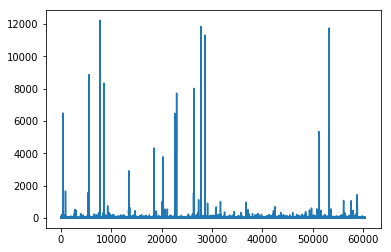

In [5]:
plt.plot(FPKM_data[0,2:])
plt.show()

# Single decision tree try

In [191]:
from sklearn import tree

In [192]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(FPKM_data[:,2:], FPKM_data[:,0])

In [193]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None,feature_names=ensemble_name) 
graph = graphviz.Source(dot_data) 
graph.render("iris") 

'iris.pdf'

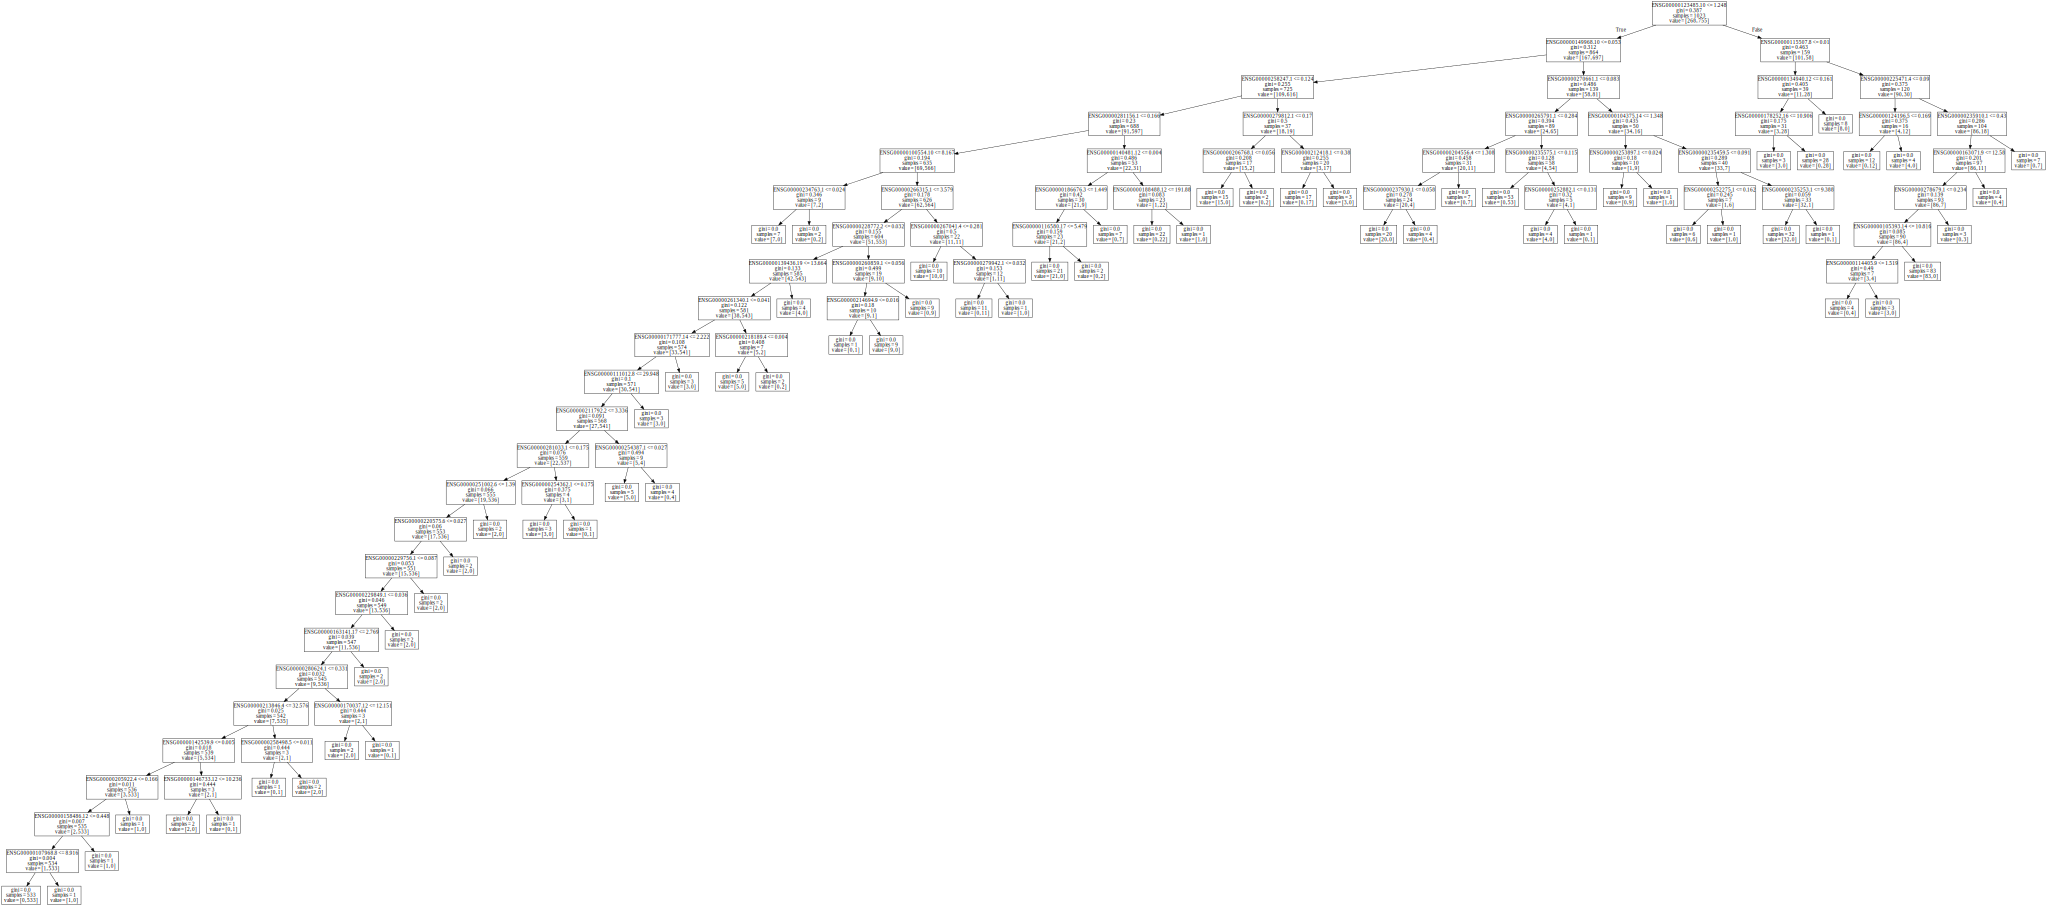

In [195]:
display(graph)

In [15]:
np.zeros((3,5),dtype='string')

TypeError: data type "string" not understood

In [23]:
test=np.array(clinical_data)

In [21]:
test[:,0].index('2797088e-f534-4c1e-abf8-cc6f832cd911')

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [52]:
FPKM_data.shape

(1023, 60485)

In [45]:
len(files)

1023

# random forest analysis

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [280]:
xtrain, xtest, ytrain, ytest = train_test_split(FPKM_data[:,2:],FPKM_data[:,0],stratify = FPKM_data[:,0])

forest = RandomForestClassifier(n_estimators=20000,random_state=2463,n_jobs=4)
forest.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20000, n_jobs=4,
            oob_score=False, random_state=2463, verbose=0,
            warm_start=False)

In [57]:
def plot_feature_importance(model):
    n_features = FPKM_data.shape[1]-2  # the -2 is due to some headers in the data set array
    plt.barh(range(n_features),model.feature_importances_, align='center')
    #plt.yticks(np.arange(n_features),ensemble_name)
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.ylim(-1,n_features)
    plt.show()
    

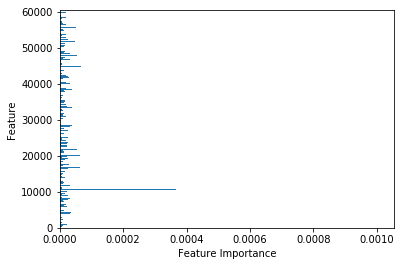

In [275]:
plot_feature_importance(forest)
plt.show()

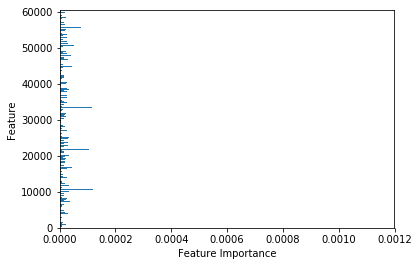

In [281]:
plot_feature_importance(forest)
plt.show()

In [52]:
plt.yticks([])

([], <a list of 0 Text yticklabel objects>)

In [12]:
ensemble_name[0]

'ENSG00000242268.2'

In [16]:
len(forest.feature_importances_)

60483

In [269]:
# sort by feature importance and display top features
feature_data = np.stack((forest.feature_importances_,ensemble_name))

In [34]:
feature_data.sort()
feature_data[0:5]

array([['0.0', '0.0', '0.0', ..., '8.45690713703161e-05',
        '8.73854386524227e-05', '8.878592614681503e-05'],
       ['ENSG00000000003.13', 'ENSG00000000005.5', 'ENSG00000000419.11',
        ..., 'ENSGR0000277120.3', 'ENSGR0000280767.1', 'ENSGR0000281849.1']],
      dtype='<U32')

In [33]:
feature_data[0:5]

array([['0.0', '0.0', '0.0', ..., '0.0', '0.0', '0.0'],
       ['ENSG00000242268.2', 'ENSG00000270112.3', 'ENSG00000167578.15',
        ..., 'ENSG00000280861.1', 'ENSG00000123685.7', 'ENSG00000181518.3']],
      dtype='<U32')

In [47]:
feature_data[0,-10:]

array(['8.051406079909216e-05', '8.070977888441706e-05',
       '8.206566103038979e-05', '8.213164961940648e-05',
       '8.252412294155468e-05', '8.360217763887569e-05',
       '8.374501671550687e-05', '8.45690713703161e-05',
       '8.73854386524227e-05', '8.878592614681503e-05'],
      dtype='<U32')

In [63]:
len(forest.feature_importances_)

60483

In [71]:
float(ensemble_name[0][-11:])

242268.2

In [282]:
feature_data = np.zeros((len(forest.feature_importances_),2))
feature_data[:,0]=forest.feature_importances_
for i in range(len(forest.feature_importances_)):
    feature_data[i,1]=np.float32(ensemble_name[i][-11:])
    
feature_data[-10:]

array([[  0.00000000e+00,   2.38244297e+05],
       [  2.03852263e-05,   1.86115109e+05],
       [  1.60726473e-06,   2.16352094e+05],
       [  2.42826901e-05,   2.67117094e+05],
       [  1.18189010e-05,   2.73233094e+05],
       [  2.07251712e-05,   1.05063172e+05],
       [  7.20072941e-05,   2.31119203e+05],
       [  0.00000000e+00,   2.80861094e+05],
       [  2.24529549e-05,   1.23685703e+05],
       [  9.25227465e-07,   1.81518297e+05]])

In [102]:
feature_data[0:5]

array([[(      0.      ,  0.), ( 242268.203125,  0.)],
       [(      0.      ,  0.), ( 270112.3125  ,  0.)],
       [(      0.      ,  0.), ( 167578.15625 ,  0.)],
       [(      0.      ,  0.), ( 273842.09375 ,  0.)],
       [(      0.      ,  0.), (  78237.5     ,  0.)]],
      dtype=[('x', '<f4'), ('y', '<f4')])

In [93]:
feature_data[:,0].argmax()

30357

In [94]:
feature_data[30357]

array([  2.56886535e-03,   1.35451110e+05])

In [283]:
sorted_data20000d=feature_data[feature_data[:,0].argsort()]

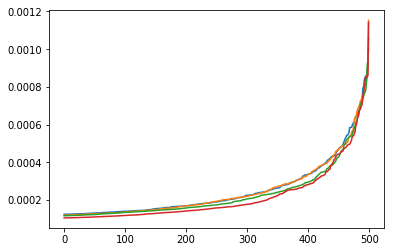

In [284]:
#plt.plot(sorted_data[-500:,0])
#plt.plot(sorted_data500[-500:,0])
#plt.plot(sorted_data1000[-500:,0])
#plt.plot(sorted_data2000[-500:,0])
plt.plot(sorted_data20000[-500:,0])
plt.plot(sorted_data20000b[-500:,0])
plt.plot(sorted_data20000c[-500:,0])
plt.plot(sorted_data20000d[-500:,0])
plt.show()

In [285]:
#print(sorted_data[-25:])
#print(sorted_data500[-25:])
#print(sorted_data1000[-25:])
#print(sorted_data2000[-25:])
print(sorted_data20000[-25:])
print(sorted_data20000b[-25:])
print(sorted_data20000c[-25:])
print(sorted_data20000d[-25:])

[[  6.11480310e-04   1.74564109e+05]
 [  6.17436597e-04   4.33558984e+04]
 [  6.39291666e-04   1.54839797e+05]
 [  6.40943745e-04   1.46670797e+05]
 [  6.47481125e-04   2.70661094e+05]
 [  6.52129957e-04   1.68779188e+05]
 [  6.56205389e-04   1.54920125e+05]
 [  6.70734796e-04   2.24132203e+05]
 [  6.73028000e-04   1.40451109e+05]
 [  6.81050693e-04   1.11206109e+05]
 [  6.84184112e-04   1.17399117e+05]
 [  7.01328945e-04   2.37649594e+05]
 [  7.22064410e-04   1.62063109e+05]
 [  7.22296872e-04   8.09861094e+04]
 [  7.58053289e-04   1.66851125e+05]
 [  7.96676839e-04   8.83251406e+04]
 [  8.00125627e-04   1.12984102e+05]
 [  8.34984662e-04   6.42183984e+04]
 [  8.50789710e-04   8.96851328e+04]
 [  8.53118359e-04   1.86185125e+05]
 [  8.58287148e-04   1.43228109e+05]
 [  8.67675169e-04   7.52181719e+04]
 [  8.93488415e-04   1.64611109e+05]
 [  9.04260930e-04   1.35451109e+05]
 [  1.06073285e-03   1.23485102e+05]]
[[  6.07901063e-04   2.24132203e+05]
 [  6.30925758e-04   1.26787109e+05]


In [286]:
sorted_ens100=sorted_data[sorted_data[:,1].argsort()]
sorted_ens500=sorted_data500[sorted_data500[:,1].argsort()]
sorted_ens1000=sorted_data1000[sorted_data1000[:,1].argsort()]
sorted_ens2000=sorted_data2000[sorted_data2000[:,1].argsort()]
sorted_ens20000=sorted_data20000[sorted_data20000[:,1].argsort()]
sorted_ens20000b=sorted_data20000b[sorted_data20000b[:,1].argsort()]
sorted_ens20000c=sorted_data20000c[sorted_data20000c[:,1].argsort()]
sorted_ens20000d=sorted_data20000d[sorted_data20000d[:,1].argsort()]

In [287]:
print(sorted_ens100[100])
print(sorted_ens500[100])
print(sorted_ens1000[100])
print(sorted_ens2000[100])
print(sorted_ens20000[100])
print(sorted_ens20000b[100])
print(sorted_ens20000c[100])
print(sorted_ens20000d[100])

[    0.          5471.14013672]
[    0.          5471.14013672]
[    0.          5471.14013672]
[  1.98867413e-05   5.47114014e+03]
[  1.63746634e-05   5.47114014e+03]
[  1.55775327e-05   5.47114014e+03]
[  1.08825988e-05   5.47114014e+03]
[  2.79730703e-05   5.47114014e+03]


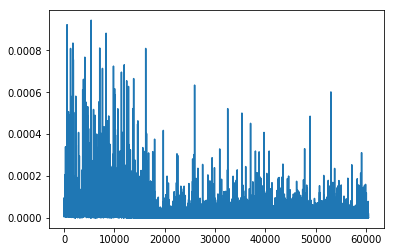

In [288]:
avg=np.zeros(len(sorted_ens100))
for i in range(len(sorted_ens100)):
    avg[i]=(sorted_ens20000[i,0]+sorted_ens20000b[i,0]+sorted_ens20000c[i,0]+sorted_ens20000d[i,0])/4
    
plt.plot(avg)
plt.show()

In [289]:
averaged=np.stack((avg,sorted_ens100[:,1]))
averaged=averaged.transpose()

In [294]:
sorted_avg=averaged[averaged[:,0].argsort()]

In [295]:
print(sorted_avg[-10:])
print(sorted_data20000[-10:])

[[  7.31209926e-04   1.66851125e+05]
 [  7.55963428e-04   8.96851328e+04]
 [  7.67445310e-04   1.12984102e+05]
 [  8.09243900e-04   7.52181719e+04]
 [  8.09289218e-04   1.86185125e+05]
 [  8.11234764e-04   1.35451109e+05]
 [  8.34906803e-04   8.83251406e+04]
 [  8.81773484e-04   1.43228109e+05]
 [  9.22726714e-04   4.33558984e+04]
 [  9.43895478e-04   1.23485102e+05]]
[[  7.96676839e-04   8.83251406e+04]
 [  8.00125627e-04   1.12984102e+05]
 [  8.34984662e-04   6.42183984e+04]
 [  8.50789710e-04   8.96851328e+04]
 [  8.53118359e-04   1.86185125e+05]
 [  8.58287148e-04   1.43228109e+05]
 [  8.67675169e-04   7.52181719e+04]
 [  8.93488415e-04   1.64611109e+05]
 [  9.04260930e-04   1.35451109e+05]
 [  1.06073285e-03   1.23485102e+05]]


In [293]:
averaged.shape

(60483, 2)

In [176]:
# from using 100, 500, 1000, 2000 trees
results = ['GTSE1','CDK1','NA','TROAP','BUB1B','NA','NEK2','KIAA1024','CDCA5','NUF2']

# from using 4 sets of 20,000 trees
results = ['HJURP','ZIC2','NUF2','TPX2','TROAP','KIF18B','GTSE1','KIF20A','BIRC5','PLK1']

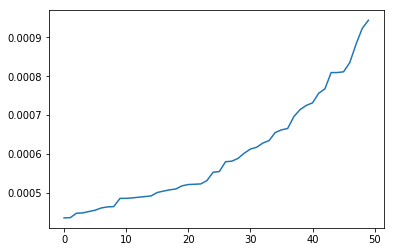

In [296]:
plt.plot(sorted_avg[-50:,0])
plt.show()

In [181]:
forest.estimator_params

('criterion',
 'max_depth',
 'min_samples_split',
 'min_samples_leaf',
 'min_weight_fraction_leaf',
 'max_features',
 'max_leaf_nodes',
 'min_impurity_decrease',
 'min_impurity_split',
 'random_state')

In [185]:
forest.estimators_[0]

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False,
            random_state=1872583848, splitter='best')

In [189]:
temp=forest.estimators_[0]

In [239]:
temp.tree_.n_node_samples

array([631, 524, 150,  95,  91,   5,   1,   4,  86,  79,   5,   3,   2,
        74,  72,  69,  68,  67,  65,   2,   1,   1,   1,   1,   3,   2,
         7,   6,   1,   4,  55,  41,  13,   4,   3,   1,   9,   8,   1,
        28,   2,  26,  25,   1,  14,   1,  13, 374, 334, 332,   3,   1,
         2, 329,   5,   1,   4, 324, 273,   1, 272, 270, 269, 268, 265,
       264, 263, 260, 259,   1, 258, 257,   1, 256, 253, 252, 251, 250,
       249,   1,   1,   1,   1,   3,   1,   2,   1,   1,   3,   2,   1,
         1,   1,   3,   2,   1,   1,   1,   2,  51,  24,  12,   9,   3,
        12,  11,   1,  27,   2,  25,   2,  40,  28,  15,  13,   7,   6,
         1,   5,  12,   2,  10, 107,  80,  45,   5,   1,   4,  40,  36,
         1,  35,  34,   1,   4,   1,   3,  35,  22,  16,  14,   1,  13,
         2,   6,  13,  12,   1,  27,   2,  25,  24,   1])

In [240]:
temp.tree_.value

array([[[ 260.,  763.]],

       [[ 177.,  679.]],

       [[  91.,  156.]],

       [[  38.,  115.]],

       [[  29.,  115.]],

       [[   8.,    1.]],

       [[   0.,    1.]],

       [[   8.,    0.]],

       [[  21.,  114.]],

       [[  13.,  111.]],

       [[   5.,    2.]],

       [[   5.,    0.]],

       [[   0.,    2.]],

       [[   8.,  109.]],

       [[   6.,  109.]],

       [[   3.,  109.]],

       [[   2.,  109.]],

       [[   1.,  109.]],

       [[   0.,  107.]],

       [[   1.,    2.]],

       [[   0.,    2.]],

       [[   1.,    0.]],

       [[   1.,    0.]],

       [[   1.,    0.]],

       [[   3.,    0.]],

       [[   2.,    0.]],

       [[   8.,    3.]],

       [[   8.,    0.]],

       [[   0.,    3.]],

       [[   9.,    0.]],

       [[  53.,   41.]],

       [[  51.,   21.]],

       [[   7.,   17.]],

       [[   6.,    1.]],

       [[   6.,    0.]],

       [[   0.,    1.]],

       [[   1.,   16.]],

       [[   0.,   16.]],

       [[   

In [236]:
features=temp.tree_.feature
threshold=temp.tree_.threshold

for i in range(len(features)):
    print(ensemble_name[features[i]],threshold[i])

ENSG00000239122.1 1.55923879147
ENSG00000169957.9 20.1619949341
ENSG00000203857.8 0.0066109392792
ENSG00000269711.1 0.0108776027337
ENSG00000280195.1 0.238334923983
ENSG00000255236.2 0.0444320961833
ENSG00000123685.7 -2.0
ENSG00000123685.7 -2.0
ENSG00000253344.1 0.00607246533036
ENSG00000203799.9 0.00725910346955
ENSG00000260898.4 0.03122385405
ENSG00000123685.7 -2.0
ENSG00000123685.7 -2.0
ENSG00000275882.1 0.0583013519645
ENSG00000268896.1 0.140572220087
ENSG00000164077.12 3.22733402252
ENSG00000184478.6 0.0129557121545
ENSG00000182632.13 1.61349606514
ENSG00000123685.7 -2.0
ENSG00000122359.16 19.8052825928
ENSG00000123685.7 -2.0
ENSG00000123685.7 -2.0
ENSG00000123685.7 -2.0
ENSG00000123685.7 -2.0
ENSG00000123685.7 -2.0
ENSG00000123685.7 -2.0
ENSG00000166341.7 6.73874282837
ENSG00000123685.7 -2.0
ENSG00000123685.7 -2.0
ENSG00000123685.7 -2.0
ENSG00000134207.13 0.542517781258
ENSG00000234718.6 0.00999111682177
ENSG00000128203.6 1.13785338402
ENSG00000133393.11 22.1748313904
ENSG0000012

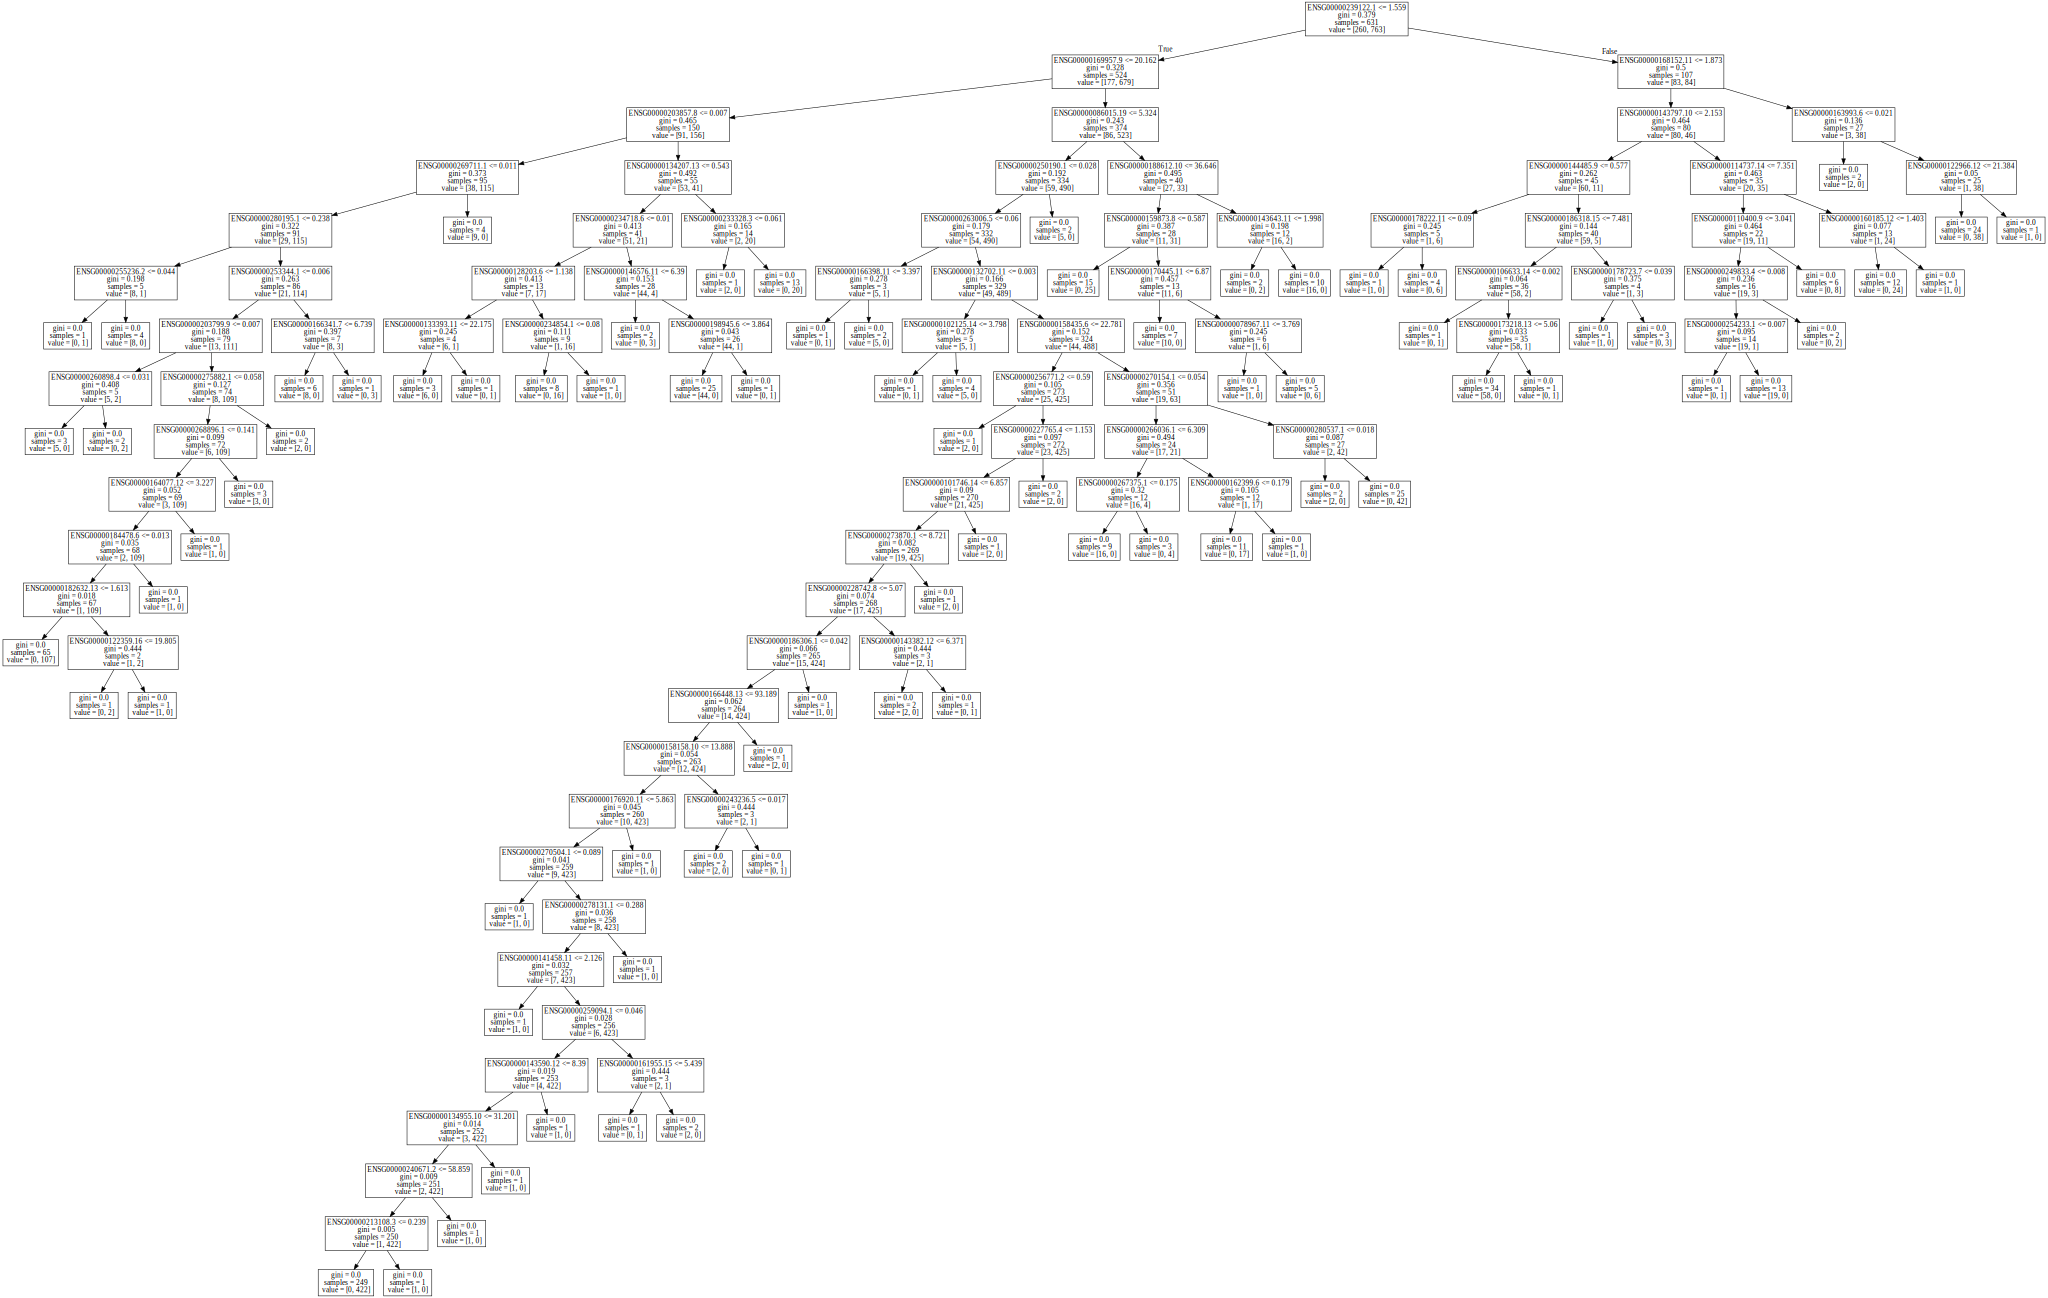

In [237]:
import graphviz 
dot_data = tree.export_graphviz(temp, out_file=None,feature_names=ensemble_name) 
graph = graphviz.Source(dot_data) 
display(graph)

In [253]:
forest.score(xtest,ytest)

0.76171875

In [244]:
FPKM_data[5:10,0]

array([ 1.,  0.,  1.,  1.,  1.])

In [336]:
#save results to files
dump(sorted_ens20000, 'kidney_20ka.joblib')
dump(sorted_ens20000b, 'kidney_20kb.joblib')
dump(sorted_ens20000c, 'kidney_20kc.joblib')
dump(sorted_ens20000d, 'kidney_20kd.joblib')

['kidney_20kd.joblib']

# Breast Cancer analysis

In [6]:
#this cell opens the metadata file and create list with: files = [case_id,file_id,file_name]
with open('../Breast clinical data/metadata.cart.2019-02-07.json') as data_file:    
    data = json.load(data_file)

#initialize the array to hold the information
files = []
    
for n in range(len(data)):
    #remove the TARGET project files since clinical data doesn't match
    if not bool('TARGET' in data[n]['associated_entities'][0]['entity_submitter_id']):
        files.append([data[n]['associated_entities'][0]['case_id'],data[n]['file_id'],data[n]['file_name']])
    
pprint(files[0:3])

[['aa4244a8-0454-4247-a1c3-357fd51746fa',
  '2237e742-56da-4688-904e-8caaba7b1831',
  '7d9d7119-4a9e-46f6-b758-153bfcc869a5.FPKM.txt.gz'],
 ['281f70c5-876f-44b3-84fb-f2302f85e74c',
  '10e813bc-63fe-4f32-a000-88527d5444b2',
  'e1f960fc-6efa-4492-9f44-8e645ec8bfc2.FPKM.txt.gz'],
 ['b6633c36-7ce4-4b69-9bf6-30b64d46c66f',
  '1d6732d2-c627-4883-b2a3-c822a5023a06',
  'a6f657a3-439e-4afd-be04-413f2ed02828.FPKM-UQ.txt.gz']]


In [7]:
clinical_data = []

with open('../Breast clinical data/clinical.tsv') as tsvin:
    tsvin = csv.reader(tsvin, delimiter='\t')
    
    firstline=True
    
    for row in tsvin:
        if firstline:
            firstline=False
        else:
        # the TARGET project stores data in the wrong columns so ignore those
            if not bool('TARGET' in str(row[1])):
                clinical_data.append(row[0])
                clinical_data.append(row[4])
                clinical_data.append(row[12])
                clinical_data.append(row[13])
                clinical_data.append(row[15])
                clinical_data.append(row[24])

clinical_data[0:3]

['02bed00f-bef7-4fb7-b243-540354990e45', '1954', '20227']

In [8]:
#grab FPKM data from files
with gzip.open('../Breast FPKM data/'+files[0][1]+'/'+files[0][2], 'rb') as f:
    row_count = sum(1 for row in f)
    
# FPKM_data will store all FPKM data in a row for all patients in the clinical data set
FPKM_data = np.zeros((len(files),row_count+7))
ensemble_name = []

for n in range(len(files)):
    with gzip.open('../Breast FPKM data/'+files[n][1]+'/'+files[n][2], 'rb') as f:
        m=2
        # add: status (0=dead, 1=alive), days at last check or days at death
        index=clinical_data.index(files[n][0])
        if clinical_data[index+3]=='alive' and not clinical_data[index+5]=='--':
            FPKM_data[n,0]=1
            FPKM_data[n,1]=float(clinical_data[index+5])
        if clinical_data[index+3]=='dead' and not clinical_data[index+4]=='--':
            FPKM_data[n,0]=0
            FPKM_data[n,1]=float(clinical_data[index+4])
        for line in f:
            string=str(line)
            FPKM_data[n,m]=float(string[string.find('\\t')+2:string.find('\\n')])
            if n==0:
                #save ensemble protein names
                ensemble_name.append(string[2:string.find('\\t')])
            m=m+1
                
print(FPKM_data[0,0:5])

[  1.00000000e+00   6.11000000e+02   1.66239197e-02   0.00000000e+00
   1.66686780e+00]


In [326]:
max(FPKM_data[:,-90])

0.0

In [329]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [9]:
xtrain, xtest, ytrain, ytest = train_test_split(FPKM_data[:,2:],FPKM_data[:,0],stratify = FPKM_data[:,0])

In [ ]:
forest = RandomForestClassifier(n_estimators=20000,random_state=2463,n_jobs=4)
forest.fit(xtrain, ytrain)

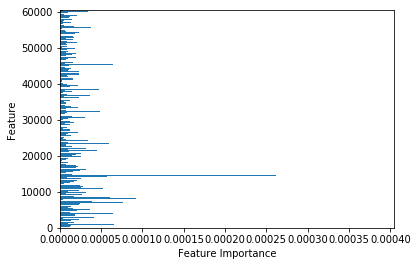

In [331]:
plot_feature_importance(forest)
plt.show()

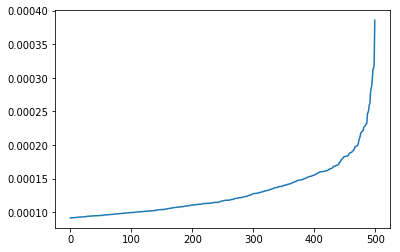

[[  2.13154733e-04   8.39377031e+04]
 [  2.18132880e-04   1.19508156e+05]
 [  2.18898798e-04   1.54370125e+05]
 [  2.20101638e-04   1.83971500e+05]
 [  2.21293242e-04   1.86675594e+05]
 [  2.21641231e-04   5.69981719e+04]
 [  2.26426544e-04   2.71949094e+05]
 [  2.27821006e-04   4.84614990e+03]
 [  2.28498778e-04   2.38698094e+05]
 [  2.29645483e-04   2.16518094e+05]
 [  2.31572263e-04   2.77569094e+05]
 [  2.32698024e-04   1.99077203e+05]
 [  2.47221814e-04   2.67784094e+05]
 [  2.48485381e-04   2.58873203e+05]
 [  2.52352834e-04   2.54796094e+05]
 [  2.59872307e-04   2.60318094e+05]
 [  2.61924179e-04   2.75701094e+05]
 [  2.77781384e-04   2.77199094e+05]
 [  2.84232582e-04   1.38722797e+05]
 [  2.88423708e-04   2.65911094e+05]
 [  2.98574220e-04   2.36634094e+05]
 [  3.12480587e-04   2.37563094e+05]
 [  3.13535914e-04   2.73643094e+05]
 [  3.21047296e-04   2.64155094e+05]
 [  3.85561264e-04   2.73988094e+05]]


In [13]:
feature_data = np.zeros((len(forest.feature_importances_),2))
feature_data[:,0]=forest.feature_importances_
for i in range(len(ensemble_name)):
    feature_data[i,1]=np.float32(ensemble_name[i][-11:])
    
feature_data[-10:]

sorted_data20000=feature_data[feature_data[:,0].argsort()]

#plt.plot(sorted_data[-500:,0])
#plt.plot(sorted_data500[-500:,0])
#plt.plot(sorted_data1000[-500:,0])
#plt.plot(sorted_data2000[-500:,0])
plt.plot(sorted_data20000[-500:,0])
#plt.plot(sorted_data20000b[-500:,0])
#plt.plot(sorted_data20000c[-500:,0])
#plt.plot(sorted_data20000d[-500:,0])
plt.show()

print(sorted_data20000[-25:])

# How to save and load to files 

In [4]:
#save tree results
from joblib import dump, load

In [337]:
#save in a compressed file to save space (raw for 20k breast data was 526 MB file)
dump(forest, 'breast_20k_rand_2463.joblib',compress=('lzma', 3))

['breast_20k_rand_2463.joblib']

In [5]:
forest = load('breast_20k_rand_2463.joblib') 

In [3]:
import graphviz 

In [10]:
forest.score(xtest,ytest)

0.96078431372549022